In [2]:
%matplotlib inline
import os
from math import pi
import openmc
import openmc.deplete
import matplotlib.pyplot as plt
import re
from matplotlib.pyplot import Line2D

In [3]:
os.system('rm *.h5 *.xml')

0

We will add an arbitrary out-of-core fuel salt depletable material, with the same material definition and placed it outside of the core region (subjected to only decay). We will then set up transfer rates for the all fuel salt inventory from in-core to out-of core and vice versa as a function of their residence times. 

In [4]:
# Instantiate some Materials and register the appropriate Nuclides
uf4 = openmc.Material(name='UF4')
uf4.set_density('g/cm3', 4.5)
uf4.add_element('U', 1., enrichment=2.4)
uf4.add_element('F', 4.)

helium = openmc.Material(name='Helium for gap')
helium.set_density('g/cm3', 0.001598)
helium.add_element('He', 2.4044e-4)

zircaloy = openmc.Material(name='Zircaloy 4')
zircaloy.set_density('g/cm3', 6.55)
zircaloy.add_element('Sn', 0.014, 'wo')
zircaloy.add_element('Fe', 0.00165, 'wo')
zircaloy.add_element('Cr', 0.001, 'wo')
zircaloy.add_element('Zr', 0.98335, 'wo')

borated_water = openmc.Material(name='Borated water')
borated_water.set_density('g/cm3', 0.740582)
borated_water.add_element('B', 4.0e-5)
borated_water.add_element('H', 5.0e-2)
borated_water.add_element('O', 2.4e-2)
borated_water.add_s_alpha_beta('c_H_in_H2O')

ofc_uf4 = uf4.clone()
ofc_uf4.name = 'UF4_ofc'
# Define overall material
material = openmc.Materials([uf4, helium, zircaloy, borated_water, ofc_uf4])

In [5]:
# Define surfaces
width = 1.25984
height = 200
ofc_r = 2
fuel_or = openmc.ZCylinder(r=0.39218, name='Fuel OR')
clad_ir = openmc.ZCylinder(r=0.40005, name='Clad IR')
clad_or = openmc.ZCylinder(r=0.45720, name='Clad OR')
wat_or = openmc.ZCylinder(r=width/2, name='H2O OR', boundary_type='reflective')
interface = openmc.ZPlane(z0=-59, name='IF')
z_top = openmc.ZPlane(z0=height/2, name='Pin TOP', boundary_type='vacuum')
z_bot = openmc.ZPlane(z0=-height/2, name='Pin BOT', boundary_type='vacuum')
ofc_surf = openmc.Sphere(x0 = 15, r = ofc_r, boundary_type = 'vacuum') 

# Define cells
fuel = openmc.Cell(fill=uf4, region=-fuel_or & -z_top & +z_bot)
gap = openmc.Cell(fill=helium, region=+fuel_or & -clad_ir & -z_top & +z_bot)
clad = openmc.Cell(fill=zircaloy, region=+clad_ir & -clad_or & -z_top & +z_bot)
water = openmc.Cell(fill=borated_water, region=+clad_or & -interface )
gas = openmc.Cell(fill=helium, region=+clad_or & +interface)
msr_uni = openmc.Universe(cells=(water, gas))
msr = openmc.Cell(name="MSR", fill=msr_uni, region=-wat_or & -z_top & +z_bot)
ofc_fuel = openmc.Cell(fill=ofc_uf4, region=-ofc_surf)
root = openmc.Universe(cells=[fuel, gap, clad, msr, ofc_fuel])
# Define overall geometry
geometry = openmc.Geometry(root)

In [6]:
# Instantiate a Settings object, set all runtime parameters, and export to XML
settings = openmc.Settings()
settings.batches = 100
settings.inactive = 10
settings.particles = 1000

# Create an initial uniform spatial source distribution over fissionable zones
bounds = [-0.62992, -0.62992, -100, 0.62992, 0.62992, 100]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
settings.source = openmc.source.IndependentSource(space=uniform_dist)

#Build the model
model = openmc.Model(geometry=geometry, materials=material, settings=settings)

<Axes: xlabel='x [cm]', ylabel='z [cm]'>

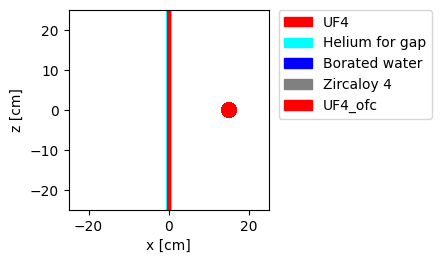

In [7]:
# Create plot
colors = {uf4:'red', helium:'cyan', borated_water: 'blue', zircaloy: 'gray', ofc_uf4: 'red'}
root.plot(width=(50, 50), origin=(0,0,0), pixels=(200, 200), basis='xz', color_by='material', colors=colors, legend=True)

In [8]:
chain_file = '/home/lorenzo/ca_depletion_chains/chain_simple.xml'
# Set material volume for depletion.
uf4.volume = pi * fuel_or.r**2 * height
ofc_uf4.volume  = 3*uf4.volume 

op = openmc.deplete.CoupledOperator(model, chain_file)
# Perform simulation using the predictor algorithm
time_steps = [1.0, 1.0, 1.0, 1.0, 1.0]  # days
power = 1.0e5  # W
integrator = openmc.deplete.PredictorIntegrator(op, time_steps, power, timestep_units='d')
integrator.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading B11 from /home/lorenzo/nuclear_data/endfb80_hdf5/B11.h5
 Reading H1 from /home/lorenzo/nuclear_data/endfb80_hdf5/H1.h5
 Reading H2 from /home/lorenzo/nuclear_data/endfb80_hdf5/H2.h5
 Reading O16 from /home/lorenzo/nuclear_data/endfb80_hdf5/O16.h5
 Reading O17 from /home/lorenzo/nuclear_data/endfb80_hdf5/O17.h5
 Reading O18 from /home/lorenzo/nuclear_data/endfb80_hdf5/O18.h5
 Reading c_H_in_H2O from /home/lorenzo/nuclear_data/endfb80_hdf5/c_H_in_H2O.h5
 Minimum neutron data temperature: 294 K
 Maximum neutron data temperature: 294 K
 Preparing distributed cell instances...
 Reading plot XML file...
 Writing summary.h5 file...
[openmc.deplete] t=0.0 s, dt=86400.0 s, source=100000.0
 Reading I135 from /home/lorenzo/nuclear_data/endfb80_hdf5/I135.h5
 Reading Xe135 from /home/lorenzo/nuclear_data/endfb80_hdf5/Xe135.h5
 Reading Xe136 from /home/lorenzo/nuclear_data/endfb80_hdf5/Xe136.h5
 Reading Cs135 from /home/lorenzo/nuclear_data/endfb80_hdf5/Cs135.h5
 Reading Gd157 from /home/lo

In [9]:
res_ref = openmc.deplete.Results('depletion_results.h5')

To simulate the continuous circulation of fuel salt from in-core to out-of-core and vice versa, we can set up inventory transfers, by making use of `TransferRates` methodology, with trasnfer rates $\lambda_i$ defined as: 

\begin{equation}
\lambda_i = \frac{1}{V_i \dot{m}_i}
\end{equation}

where $V_i$ is the fuel salt volume of the material we're transferring from and $\dot{m}_i$ the flow rate. 

In this example, we will set transfer rates from in-core to out-of-core and vice versa for the all fuel salt invetories, with the fuel salt out-of-core volume being 3 times larger than the one in-core.

We also need to activate the `destination_material` argument to keep track of the transfers between different deplatable materials. 

In [10]:
# Transfer all elements from in-core to out-of-core and vice-versa
all_elements = list(openmc.data.ELEMENT_SYMBOL.values())
all_elements.remove('He') #still haven't figure out here
flow_rate = 0.1 #litres/sec
lambda_in = 1 / (uf4.volume / 1000 / flow_rate)
lambda_out = 1 / (ofc_uf4.volume / 1000 / flow_rate)
op = openmc.deplete.CoupledOperator(model, chain_file)
integrator = openmc.deplete.PredictorIntegrator(op, time_steps, power, timestep_units='d')
integrator.add_transfer_rate(uf4, all_elements, lambda_in, destination_material=ofc_uf4)
integrator.add_transfer_rate(ofc_uf4, all_elements, lambda_out, destination_material=uf4)
integrator.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading B11 from /home/lorenzo/nuclear_data/endfb80_hdf5/B11.h5
 Reading H1 from /home/lorenzo/nuclear_data/endfb80_hdf5/H1.h5
 Reading H2 from /home/lorenzo/nuclear_data/endfb80_hdf5/H2.h5
 Reading O16 from /home/lorenzo/nuclear_data/endfb80_hdf5/O16.h5
 Reading O17 from /home/lorenzo/nuclear_data/endfb80_hdf5/O17.h5
 Reading O18 from /home/lorenzo/nuclear_data/endfb80_hdf5/O18.h5
 Reading c_H_in_H2O from /home/lorenzo/nuclear_data/endfb80_hdf5/c_H_in_H2O.h5
 Minimum neutron data temperature: 0 K
 Maximum neutron data temperature: 1.7976931348623157e+308 K
 Preparing distributed cell instances...
 Reading plot XML file...
 Writing summary.h5 file...
[openmc.deplete] t=0.0 s, dt=86400.0 s, source=100000.0
 Reading I135 from /home/lorenzo/nuclear_data/endfb80_hdf5/I135.h5
 Reading Xe135 from /home/lorenzo/nuclear_data/endfb80_hdf5/Xe135.h5
 Reading Xe136 from /home/lorenzo/nuclear_data/endfb80_hdf5/Xe136.h5
 Reading Cs135 from /home/lorenzo/nuclear_data/endfb80_hdf5/Cs135.h5
 Reading G

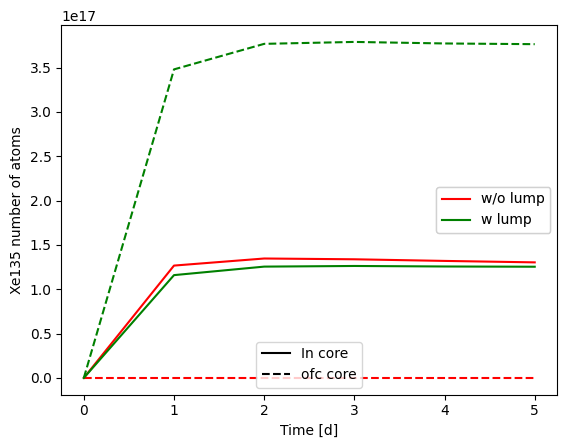

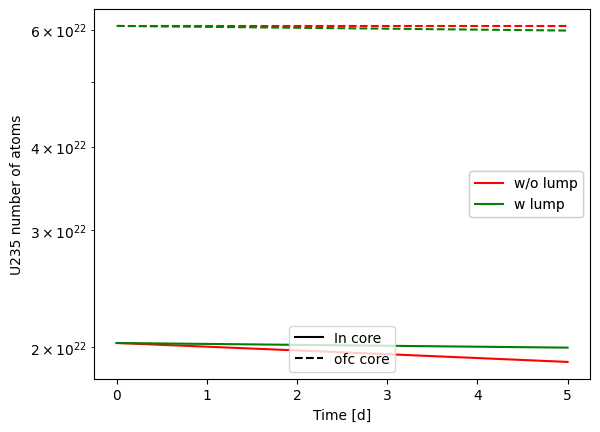

In [12]:
res_lump = openmc.deplete.Results('depletion_results.h5')

time, xe135_ref_c = res_ref.get_atoms(uf4, 'Xe135')
_, xe135_ref_ofc = res_ref.get_atoms(ofc_uf4, 'Xe135')
_, xe135_lump_c = res_lump.get_atoms(uf4, 'Xe135')
_, xe135_lump_ofc = res_lump.get_atoms(ofc_uf4, 'Xe135')
_, u235_ref_c = res_ref.get_atoms(uf4, 'U235')
_, u235_ref_ofc = res_ref.get_atoms(ofc_uf4, 'U235')
_, u235_lump_c = res_lump.get_atoms(uf4, 'U235')
_, u235_lump_ofc = res_lump.get_atoms(ofc_uf4, 'U235')

line1 = Line2D([0], [0], color='black')
line2 = Line2D([0], [0], linestyle='--', color='black')
line3 = Line2D([0], [0], color='r')
line4 = Line2D([0], [0], color='g')
labels1 = ['In core', 'ofc core']
labels2 = ['w/o lump', 'w lump']
fig, ax = plt.subplots()
ax.plot(xe135_ref_c, color='r')
ax.plot(xe135_ref_ofc, '--', color='r')
ax.plot(xe135_lump_c, color='g')
ax.plot(xe135_lump_ofc, '--', color='g')
leg1=plt.legend([line1, line2],labels1,loc='lower center')
leg2=plt.legend([line3, line4],labels2,loc='center right')
ax.add_artist(leg1)
ax.add_artist(leg2)
ax.set_xlabel('Time [d]')
ax.set_ylabel('Xe135 number of atoms')
#ax.set_yscale('log')
plt.show()

line1 = Line2D([0], [0], color='black')
line2 = Line2D([0], [0], linestyle='--', color='black')
line3 = Line2D([0], [0], color='r')
line4 = Line2D([0], [0], color='g')
labels1 = ['In core', 'ofc core']
labels2 = ['w/o lump', 'w lump']
fig, ax = plt.subplots()
ax.plot(u235_ref_c, color='r')
ax.plot(u235_ref_ofc, '--', color='r')
ax.plot(u235_lump_c, color='g')
ax.plot(u235_lump_ofc, '--', color='g')
leg1=plt.legend([line1, line2],labels1,loc='lower center')
leg2=plt.legend([line3, line4],labels2,loc='center right')
ax.add_artist(leg1)
ax.add_artist(leg2)
ax.set_xlabel('Time [d]')
ax.set_ylabel('U235 number of atoms')
ax.set_yscale('log')
plt.show()

As expected, in the lump case Xe135 starts accumulate early on in the out-of-core zone, due to the lower circulation time than in-core and no presence of neutron absorption reactions (decay-only region). 
On the other hand, U235 distribution between in-core and out-of-core is initially the same for the two cases and we start observing the small effect of fresh fissile being transferred from the out-of-core to the the in-core region in the lump case, only after 1 simulation day. 